In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
import matplotlib.gridspec as gridspec
warnings.filterwarnings('ignore')

In [2]:
!wget -q --show-progress -O food_facts.csv.gz \
  "https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv.gz"

print("Download complete")

food_facts.csv.gz   100%[===================>]   1.14G  32.8MB/s    in 37s     
Download complete


In [3]:
# The full dataset has 180+ columns. We only need these 8.
COLUMNS_NEEDED = [
    'product_name',
    'categories_tags',
    'ingredients_text',
    'energy_100g',
    'sugars_100g',
    'proteins_100g',
    'fat_100g',
    'fiber_100g',
]

print(f"Loaded {len(COLUMNS_NEEDED)} columns out of 180+")

Loaded 8 columns out of 180+


In [4]:
df_raw = pd.read_csv(
    'food_facts.csv.gz',
    sep='\t',
    nrows=500_000,
    usecols=COLUMNS_NEEDED,
    low_memory=False,
    on_bad_lines='skip'
)

print(f"Loaded {len(df_raw):,} rows ")
print(f"Shape: {df_raw.shape}")
df_raw.tail(5)

Loaded 500,000 rows 
Shape: (500000, 8)


,product_name,categories_tags,ingredients_text,energy_100g,fat_100g,sugars_100g,fiber_100g,proteins_100g
499995,Orange Juice,NaN,orange juice,192.0,0.0,9.583333,0.416667,0.833333
499996,Orange Juice Medium Pulp,NaN,NaN,192.0,0.0,9.583333,0.416667,0.833333
499997,Black sweet tea,"en:plant-based-foods-and-beverages,en:beverage...",NaN,130.0,0.0,7.605634,0.000000,0.000000
499998,Homestyle Lemonade,NaN,NaN,192.0,0.0,11.666667,0.000000,0.000000
499999,Large Grade A Vegetarian Fed Cage Free Eggs,"en:farming-products,en:eggs,en:chicken-eggs,en...",NaN,586.0,10.0,0.000000,0.000000,12.000000


In [5]:
# Data Exploration

print(" DATASET OVERVIEW \n")
print(f"Total rows: {len(df_raw):,}")
print(f"Total columns: {df_raw.shape[1]}")
print("\n NULL VALUE COUNT (per column) ")
print(df_raw.isnull().sum())
print("\n DATA TYPES ")
print(df_raw.dtypes)
print("\n BASIC STATISTICS (numeric columns) ")
df_raw[['sugars_100g', 'proteins_100g', 'fat_100g', 'fiber_100g']].describe()

 DATASET OVERVIEW 

Total rows: 500,000
Total columns: 8

 NULL VALUE COUNT (per column) 
product_name         15579
categories_tags     229747
ingredients_text    231191
energy_100g          74707
fat_100g             77345
sugars_100g          93436
fiber_100g          177542
proteins_100g        76871
dtype: int64

 DATA TYPES 
product_name         object
categories_tags      object
ingredients_text     object
energy_100g         float64
fat_100g            float64
sugars_100g         float64
fiber_100g          float64
proteins_100g       float64
dtype: object

 BASIC STATISTICS (numeric columns) 


,sugars_100g,proteins_100g,fat_100g,fiber_100g
count,406564.000000,423129.000000,422655.000000,322458.000000
mean,17.542264,8.657712,14.869983,3.252585
std,43.720976,23.888684,41.107267,25.655246
min,-1.450000,-12.600000,0.000000,-44.700000
25%,1.000000,0.770000,0.000000,0.000000
50%,5.000000,5.000000,5.260000,1.400000
75%,22.200000,10.800000,20.000000,3.571429
max,11111.000000,7270.000000,11111.000000,11800.000000


In [6]:
df_clean = df_raw.dropna(subset=['product_name', 'sugars_100g', 'proteins_100g'])

rows_dropped = len(df_raw) - len(df_clean)
print(f"Rows before cleaning: {len(df_raw):,}")
print(f"Rows dropped (missing critical values): {rows_dropped:,}")
print(f"Rows remaining: {len(df_clean):,}")

Rows before cleaning: 500,000
Rows dropped (missing critical values): 98,913
Rows remaining: 401,087


In [7]:
# Define valid ranges
VALID_MIN = 0
VALID_MAX = 100

df_clean = df_clean[
    (df_clean['sugars_100g']   >= VALID_MIN) & (df_clean['sugars_100g']   <= VALID_MAX) &
    (df_clean['proteins_100g'] >= VALID_MIN) & (df_clean['proteins_100g'] <= VALID_MAX) &
    (df_clean['fat_100g'].isna() | ((df_clean['fat_100g'] >= VALID_MIN) & (df_clean['fat_100g'] <= VALID_MAX))) &
    (df_clean['fiber_100g'].isna() | ((df_clean['fiber_100g'] >= VALID_MIN) & (df_clean['fiber_100g'] <= VALID_MAX)))
]

print(f"Rows after removing impossible values: {len(df_clean):,}")

Rows after removing impossible values: 391,528


In [8]:
# clean data

print(" CLEAN DATASET STATS \n")
print(df_clean[['sugars_100g', 'proteins_100g', 'fat_100g', 'fiber_100g']].describe().round(2))

print("\n SAMPLE PRODUCTS ")
print(df_clean[['product_name', 'sugars_100g', 'proteins_100g']].sample(10, random_state=42))

df_clean.to_csv('food_facts_clean.csv', index=False)
print("\nClean dataset saved as food_facts_clean.csv")
print(f"Final shape: {df_clean.shape}")

 CLEAN DATASET STATS 

       sugars_100g  proteins_100g   fat_100g  fiber_100g
count    391528.00      391528.00  390603.00   307274.00
mean         14.79           7.72      11.93        2.83
std          20.52           9.84      16.07        5.17
min           0.00           0.00       0.00        0.00
25%           1.10           0.83       0.00        0.00
50%           5.00           4.93       5.00        1.40
75%          21.25          10.53      18.75        3.57
max         100.00         100.00     100.00      100.00

 SAMPLE PRODUCTS 
                                      product_name  sugars_100g  proteins_100g
316270                         Breaded squid rings     1.000000       7.000000
130944  100% Whole Grain Rolled Oats Old Fashioned     1.000000       5.000000
264987                              Grape seed oil     0.000000       0.000000
20828                           Maple Syrup Sachet    66.700000       0.000000
449521                 Taro Cake with Dried Shrimp

In [9]:
print(" SAMPLE OF RAW categories_tags VALUES \n")

# Show 100 examples
sample_tags = df_clean['categories_tags'].dropna().sample(100, random_state=42)
for tag in sample_tags:
    print(tag)
    print("---")

 SAMPLE OF RAW categories_tags VALUES 

en:desserts,en:frozen-foods,en:frozen-desserts,en:mochi-ice-cream
---
en:plant-based-foods-and-beverages,en:plant-based-foods,en:breakfasts,en:cereals-and-potatoes,en:cereals-and-their-products,en:breakfast-cereals,en:mueslis
---
en:breakfasts,en:spreads,en:sweet-spreads,en:bee-products,en:farming-products,en:sweeteners,en:honeys
---
en:condiments,en:sauces,en:groceries
---
en:dietary-supplements
---
en:snacks
---
en:null
---
en:dairies,en:fermented-foods,en:fermented-milk-products,en:cheeses
---
en:snacks
---
en:snacks,en:sweet-snacks,en:confectioneries
---
en:beverages
---
en:undefined
---
en:desserts,en:frozen-foods,en:frozen-desserts,en:ice-creams-and-sorbets,en:ice-creams,en:ice-cream-sandwiches
---
en:plant-based-foods-and-beverages,en:beverages,en:plant-based-beverages,en:fruit-based-beverages,en:juices-and-nectars,en:fruit-juices,en:orange-juices
---
en:sweeteners,en:syrups,en:simple-syrups,en:maple-syrups
---
en:dairies,en:milks,en:cow-m

In [10]:

# Step 1: Define what to EXCLUDE first
EXCLUDE_PATTERNS = [
    'beverage',
    'juice',
    'soda',
    'milk',
    'cream',
    'ice-cream',
    'frozen-dessert',
    'frozen-food',
    'mochi-ice',
    'sorbet',
    'soup',
    'sauce',
    'condiment',
    'pasta',
    'rice-dish',
    'meal',
    'bread',
    'cereal',
    'muesli',
    'supplement',
    'syrup',
    'honey',
    'spread',
    'pizza',
    'meat',
    'chicken',
    'vegetable',
    'tomato',
    'legume',
    'canned-bean',
]

# Step 2: Define SNACK category mapping (priority ordered — first match wins)
CATEGORY_MAP = [
    # Protein / Fitness Bars — most specific, highest priority
    ('protein-bar',             'Protein & Fitness Bars'),
    ('energy-bar',              'Protein & Fitness Bars'),
    ('cereal-bar',              'Protein & Fitness Bars'),
    ('granola-bar',             'Protein & Fitness Bars'),
    ('nutrition-bar',           'Protein & Fitness Bars'),
    ('sport',                   'Protein & Fitness Bars'),

    # Chips & Savory Snacks
    ('chips-and-fries',         'Chips & Savory Snacks'),
    ('potato-crisp',            'Chips & Savory Snacks'),
    ('crisps',                  'Chips & Savory Snacks'),
    ('bbq-chip',                'Chips & Savory Snacks'),
    ('chip',                    'Chips & Savory Snacks'),
    ('pretzel',                 'Chips & Savory Snacks'),
    ('popcorn',                 'Chips & Savory Snacks'),
    ('puffed',                  'Chips & Savory Snacks'),
    ('salty-snack',             'Chips & Savory Snacks'),
    ('salted-snack',            'Chips & Savory Snacks'),
    ('savory-snack',            'Chips & Savory Snacks'),
    ('crackers-appetizer',      'Chips & Savory Snacks'),
    ('cracker',                 'Chips & Savory Snacks'),

    # Cookies & Biscuits
    ('biscuits-and-cakes',      'Cookies & Biscuits'),
    ('biscuit',                 'Cookies & Biscuits'),
    ('cookie',                  'Cookies & Biscuits'),
    ('wafer',                   'Cookies & Biscuits'),
    ('brownie',                 'Cookies & Biscuits'),
    ('toaster-pastri',          'Cookies & Biscuits'),
    ('pastri',                  'Cookies & Biscuits'),

    # Candy & Confectionery
    ('confectioner',            'Candy & Confectionery'),
    ('candies',                 'Candy & Confectionery'),
    ('candy',                   'Candy & Confectionery'),
    ('gummi',                   'Candy & Confectionery'),
    ('gummy',                   'Candy & Confectionery'),
    ('jelly-bean',              'Candy & Confectionery'),
    ('lollipop',                'Candy & Confectionery'),
    ('caramel',                 'Candy & Confectionery'),
    ('chocolate',               'Candy & Confectionery'),
    ('sweet-snack',             'Candy & Confectionery'),

    # Nuts & Seeds
    ('roasted-nut',             'Nuts & Seeds'),
    ('roasted-peanut',         'Nuts & Seeds'),
    ('trail-mix',               'Nuts & Seeds'),
    ('nut',                     'Nuts & Seeds'),
    ('seed',                    'Nuts & Seeds'),
    ('almond',                  'Nuts & Seeds'),
    ('peanut',                  'Nuts & Seeds'),
    ('cashew',                  'Nuts & Seeds'),

    # Dairy Snacks
    ('yogurt',                  'Dairy & Yogurt Snacks'),
    ('yoghurt',                 'Dairy & Yogurt Snacks'),
    ('cheese-snack',            'Dairy & Yogurt Snacks'),
    ('dairy-snack',             'Dairy & Yogurt Snacks'),

    # Fruit & Vegetable Snacks (room temp only — dried/packaged)
    ('dried-fruit',             'Fruit & Veg Snacks'),
    ('fruit-snack',             'Fruit & Veg Snacks'),
    ('fruit-bar',               'Fruit & Veg Snacks'),
    ('fruit-based-food',        'Fruit & Veg Snacks'),
    ('fruits-based-food',       'Fruit & Veg Snacks'),
    ('vegetable-chip',          'Fruit & Veg Snacks'),
    ('dried-vegetable',         'Fruit & Veg Snacks'),

    # General Snacks — broad catch-all, always last
    ('snack',                   'General Snacks'),
]

print(f" Exclusion patterns defined: {len(EXCLUDE_PATTERNS)}")
print(f" Category rules defined: {len(CATEGORY_MAP)}")
print(f" Covering {len(set(v for _, v in CATEGORY_MAP))} unique categories")

 Exclusion patterns defined: 30
 Category rules defined: 56
 Covering 8 unique categories


In [11]:
def assign_category(tags_string):
    """
    Takes a raw tags string, returns a clean category label or None.

    Logic:
    1. Null/undefined tags → None (skip)
    2. Matches an exclusion pattern → None (not a snack)
    3. Matches a category keyword → return that category
    4. No match → None (uncategorized, skip)
    """

    # Guard: null values
    if pd.isna(tags_string):
        return None

    tags_lower = tags_string.lower()

    # Guard: garbage tags like en:null, en:undefined
    if tags_lower.strip() in ('en:null', 'en:undefined', 'en:null,', ''):
        return None

    # Step 1: Check exclusions FIRST
    # If this product matches any exclusion pattern, it's not a snack — skip it
    for exclude in EXCLUDE_PATTERNS:
        if exclude in tags_lower:
            # Special case: "vegetable-chip" should NOT be excluded
            # even though it contains "vegetable"
            if exclude == 'vegetable' and 'vegetable-chip' in tags_lower:
                continue
            return None

    # Step 2: Match to a snack category
    for keyword, category in CATEGORY_MAP:
        if keyword in tags_lower:
            return category

    return None


# Test with real examples from your actual data
test_cases = [
    ("Mochi ice cream",     "en:desserts,en:frozen-foods,en:frozen-desserts,en:mochi-ice-cream"),
    ("Potato crisps",       "en:snacks,en:salty-snacks,en:chips-and-fries,en:crisps,en:potato-crisps"),
    ("Peanuts",             "en:legumes-and-their-products,en:nuts,en:roasted-nuts,en:peanuts"),
    ("Gummi candies",       "en:snacks,en:sweet-snacks,en:confectioneries,en:candies,en:gummi-candies"),
    ("Biscuits",            "en:snacks,en:sweet-snacks,en:biscuits-and-cakes,en:biscuits"),
    ("Orange juice",        "en:beverages,en:fruit-juices,en:orange-juices"),
    ("Toaster pastries",    "en:snacks,en:sweet-snacks,en:biscuits-and-cakes,en:pastries,en:toaster-pastries"),
    ("en:null tag",         "en:null"),
    ("Soda",                "en:beverages,en:carbonated-drinks,en:sodas"),
    ("BBQ chips",           "en:bbq-chips"),
    ("Crackers",            "en:snacks,en:salty-snacks,en:biscuits-and-crackers,en:crackers"),
    ("Vegetable chips",     "en:snacks,en:salty-snacks,en:vegetable-chips"),  # should STAY
]

print("=== CLASSIFICATION TEST (with real tag patterns) ===\n")
for name, tags in test_cases:
    result = assign_category(tags)
    status = "added" if result else " (excluded)"
    print(f"{status}  {name:<20} → {result}")

=== CLASSIFICATION TEST (with real tag patterns) ===

 (excluded)  Mochi ice cream      → None
added  Potato crisps        → Chips & Savory Snacks
 (excluded)  Peanuts              → None
added  Gummi candies        → Candy & Confectionery
added  Biscuits             → Cookies & Biscuits
 (excluded)  Orange juice         → None
added  Toaster pastries     → Cookies & Biscuits
 (excluded)  en:null tag          → None
 (excluded)  Soda                 → None
added  BBQ chips            → Chips & Savory Snacks
added  Crackers             → Chips & Savory Snacks
added  Vegetable chips      → Chips & Savory Snacks


In [12]:
# This creates a new column called 'primary_category'
df_clean['primary_category'] = df_clean['categories_tags'].apply(assign_category)

#  filter OUT rows where primary_category is None

df_snacks = df_clean[df_clean['primary_category'].notna()].copy()

print(f"\nTotal rows before snack filter: {len(df_clean):,}")
print(f"Snack products identified:      {len(df_snacks):,}")
print(f"Non-snack rows removed:         {len(df_clean) - len(df_snacks):,}")


Total rows before snack filter: 391,528
Snack products identified:      54,169
Non-snack rows removed:         337,359


 CATEGORY DISTRIBUTION 

primary_category
General Snacks            16835
Candy & Confectionery     15717
Cookies & Biscuits        13810
Chips & Savory Snacks      7620
Nuts & Seeds                105
Fruit & Veg Snacks           38
Protein & Fitness Bars       24
Dairy & Yogurt Snacks        20

Total snack products: 54,169


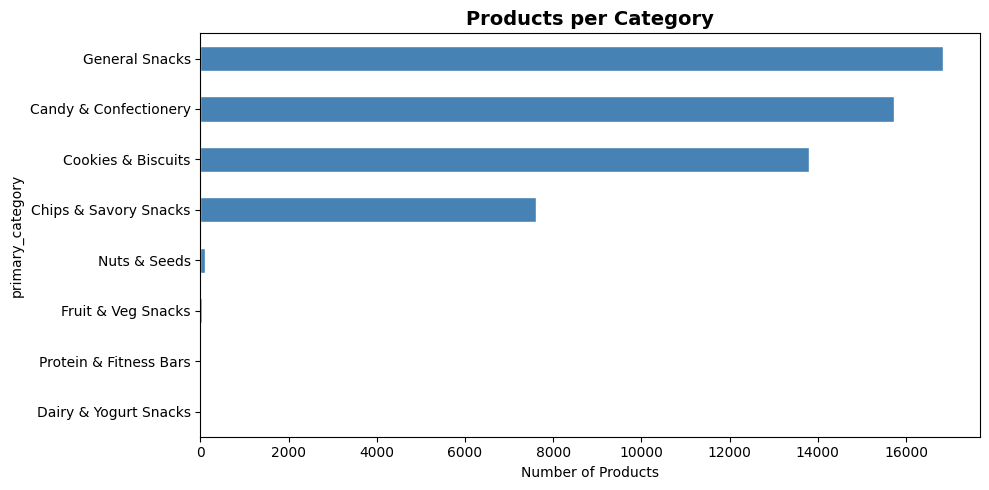

Chart saved


In [13]:
category_counts = df_snacks['primary_category'].value_counts()

print(" CATEGORY DISTRIBUTION \n")
print(category_counts.to_string())
print(f"\nTotal snack products: {len(df_snacks):,}")

# Visualize it
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))
category_counts.plot(kind='barh', ax=ax, color='steelblue', edgecolor='white')
ax.set_xlabel('Number of Products')
ax.set_title('Products per Category', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('category_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart saved")

In [14]:
summary = df_snacks.groupby('primary_category').agg(
    product_count   = ('product_name',  'count'),
    avg_sugar       = ('sugars_100g',   'mean'),
    avg_protein     = ('proteins_100g', 'mean'),
    avg_fat         = ('fat_100g',      'mean'),
    median_sugar    = ('sugars_100g',   'median'),
    median_protein  = ('proteins_100g', 'median'),
).round(2).sort_values('avg_sugar', ascending=False)

print(" NUTRITIONAL PROFILE BY CATEGORY \n")
print(summary.to_string())

# Save  snack dataset
df_snacks.to_csv('food_facts_snacks.csv', index=False)
print("\n Snack dataset saved as food_facts_snacks.csv")

 NUTRITIONAL PROFILE BY CATEGORY 

                        product_count  avg_sugar  avg_protein  avg_fat  median_sugar  median_protein
primary_category                                                                                    
Candy & Confectionery           15717      54.00         3.37    12.65         54.29            3.00
Fruit & Veg Snacks                 38      51.72         3.62     3.02         52.60            1.96
Cookies & Biscuits              13810      29.06         5.28    16.70         30.50            4.60
Nuts & Seeds                      105      19.08        10.36    27.47         10.00           10.00
General Snacks                  16835      17.54        10.70    26.46          7.14            7.14
Dairy & Yogurt Snacks              20      15.63         8.83    10.05          7.39            4.35
Chips & Savory Snacks            7620       8.23         5.15    14.65          3.33            5.84
Protein & Fitness Bars             24       4.24        

# Data Visualization

In [15]:



plt.rcParams.update({
    'figure.facecolor':     'white',
    'axes.facecolor':       '#F8F9FA',
    'axes.grid':            True,
    'grid.color':           '#E0E0E0',
    'grid.linewidth':       0.7,
    'grid.alpha':           0.8,
    'axes.spines.top':      False,
    'axes.spines.right':    False,
    'axes.spines.left':     True,
    'axes.spines.bottom':   True,
    'axes.labelsize':       12,
    'axes.titlesize':       14,
    'axes.titleweight':     'bold',
    'xtick.labelsize':      10,
    'ytick.labelsize':      10,
    'legend.fontsize':      10,
    'legend.framealpha':    0.9,
    'font.family':          'sans-serif',
})

CATEGORY_COLORS = {
    'Candy & Confectionery':    '#E63946',
    'Cookies & Biscuits':       '#F4A261',
    'Chips & Savory Snacks':    '#E9C46A',
    'General Snacks':           '#A8DADC',
    'Fruit & Veg Snacks':       '#52B788',
    'Nuts & Seeds':             '#2D6A4F',
    'Dairy & Yogurt Snacks':    '#457B9D',
    'Protein & Fitness Bars':   '#1D3557',
}

In [16]:
try:
    df_snacks
    print(f"df_snacks in memory: {len(df_snacks):,} rows")
except NameError:
    df_snacks = pd.read_csv('food_facts_snacks.csv')
    print(f"Reloaded: {len(df_snacks):,} rows")

# Cap at 99th percentile for visual clarity — all data still in df_snacks
# We only cap for PLOTTING, not for stats
p99_sugar   = df_snacks['sugars_100g'].quantile(0.99)
p99_protein = df_snacks['proteins_100g'].quantile(0.99)

df_plot = df_snacks[
    (df_snacks['sugars_100g']   <= p99_sugar) &
    (df_snacks['proteins_100g'] <= p99_protein)
].copy()

print(f"Rows available for plotting: {len(df_plot):,}")
print(f"(99th pct: sugar={p99_sugar:.1f}g, protein={p99_protein:.1f}g)")

df_snacks in memory: 54,169 rows
Rows available for plotting: 53,112
(99th pct: sugar=91.7g, protein=33.3g)


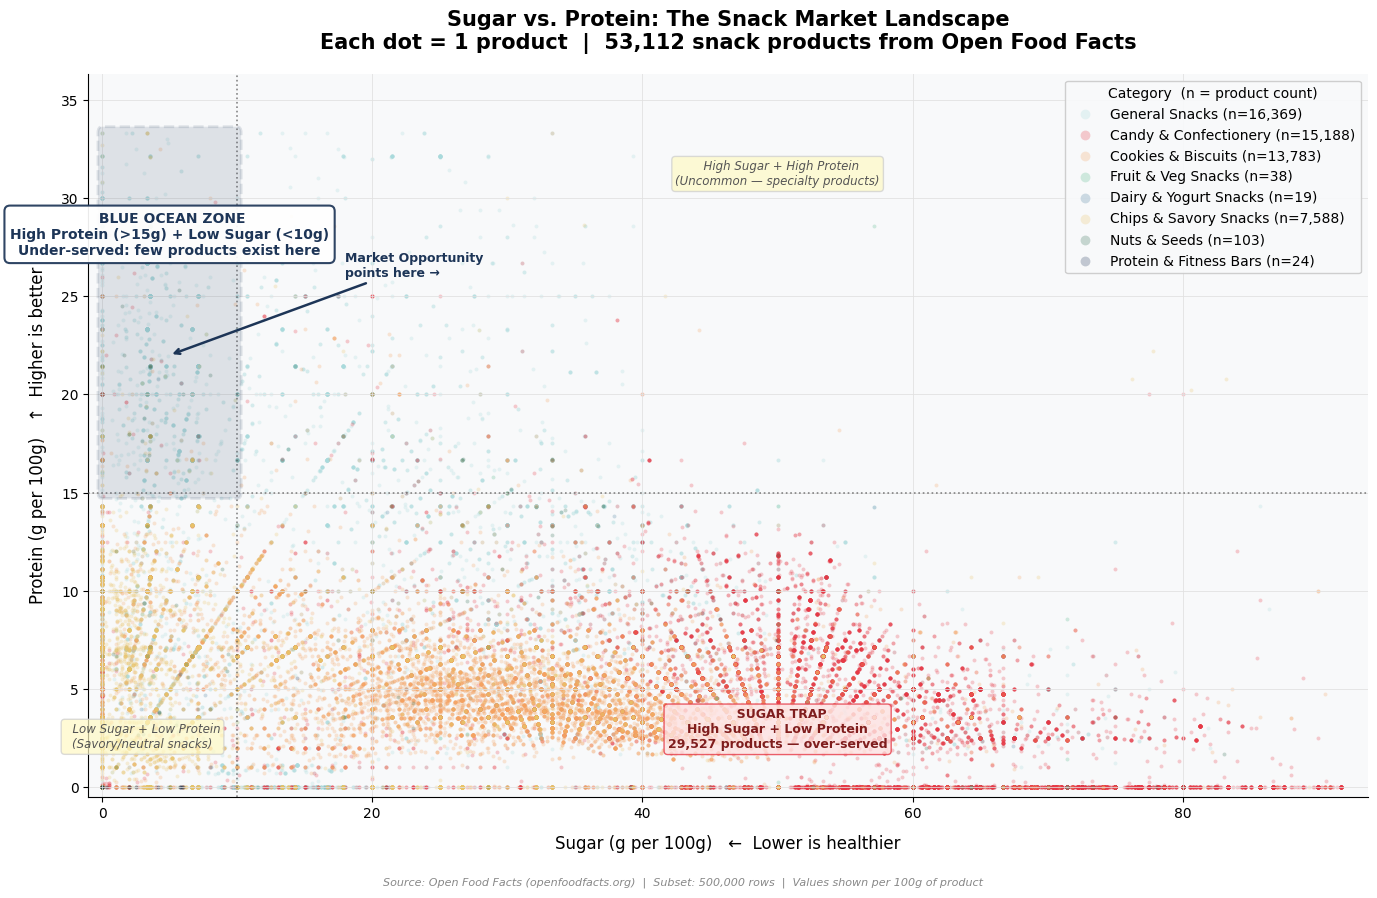

Scatter plot saved as scatter_plot.png


In [17]:
fig, ax = plt.subplots(figsize=(14, 9))

PLOT_ORDER = [
    'General Snacks',
    'Candy & Confectionery',
    'Cookies & Biscuits',
    'Fruit & Veg Snacks',
    'Dairy & Yogurt Snacks',
    'Chips & Savory Snacks',
    'Nuts & Seeds',
    'Protein & Fitness Bars',
]

for category in PLOT_ORDER:
    subset = df_plot[df_plot['primary_category'] == category]
    ax.scatter(
        subset['sugars_100g'],
        subset['proteins_100g'],
        c=CATEGORY_COLORS[category],
        label=f"{category} (n={len(subset):,})",
        alpha=0.25,
        s=8,
        linewidths=0,
        rasterized=True,
    )

#  Blue Ocean Zone rectangle
blue_ocean_rect = FancyBboxPatch(
    (0, 15),
    10, p99_protein - 15,
    boxstyle="round,pad=0.3",
    facecolor='#1D3557',
    edgecolor='#1D3557',
    alpha=0.12,
    linewidth=2,
    linestyle='--',
    zorder=5
)
ax.add_patch(blue_ocean_rect)

# Blue Ocean label inside the box
ax.text(
    5, p99_protein * 0.88,          \
    ' BLUE OCEAN ZONE\n'
    'High Protein (>15g) + Low Sugar (<10g)\n'
    'Under-served: few products exist here',
    fontsize=10,
    fontweight='bold',
    color='#1D3557',
    ha='center',
    va='top',
    zorder=6,
    bbox=dict(
        boxstyle='round,pad=0.4',
        facecolor='white',
        edgecolor='#1D3557',
        alpha=0.92,
        linewidth=1.5
    )
)

# Quadrant divider lines
ax.axhline(y=15, color='#555555', linewidth=1.2, linestyle=':', alpha=0.7, zorder=4)
ax.axvline(x=10, color='#555555', linewidth=1.2, linestyle=':', alpha=0.7, zorder=4)

# Quadrant labels in the three "non-blue-ocean" corners
ax.text(50, p99_protein * 0.92,
        '  High Sugar + High Protein\n(Uncommon — specialty products)',
        fontsize=8.5, color='#555', ha='center', style='italic',
        bbox=dict(boxstyle='round', facecolor='#FFF9C4', alpha=0.7, edgecolor='#ccc'))

ax.text(50, 2,
        '  SUGAR TRAP\n'
        'High Sugar + Low Protein\n'
        '29,527 products — over-served',
        fontsize=9, color='#7f1d1d', ha='center', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='#FEE2E2', alpha=0.8, edgecolor='#E63946'))

ax.text(3, 2,
        '  Low Sugar + Low Protein\n(Savory/neutral snacks)',
        fontsize=8.5, color='#555', ha='center', style='italic',
        bbox=dict(boxstyle='round', facecolor='#FFF9C4', alpha=0.7, edgecolor='#ccc'))

#  Arrow pointing to the opportunity
ax.annotate(
    'Market Opportunity\npoints here →',
    xy=(5, 22),
    xytext=(18, 26),
    fontsize=9,
    color='#1D3557',
    fontweight='bold',
    arrowprops=dict(
        arrowstyle='->', color='#1D3557', lw=1.8
    )
)

#  Titles and labels
ax.set_title(
    'Sugar vs. Protein: The Snack Market Landscape\n'
    'Each dot = 1 product  |  53,112 snack products from Open Food Facts',
    fontsize=15,
    fontweight='bold',
    pad=18
)
ax.set_xlabel('Sugar (g per 100g)   ←  Lower is healthier', fontsize=12, labelpad=10)
ax.set_ylabel('Protein (g per 100g)   ↑  Higher is better', fontsize=12, labelpad=10)

#  Axis limits with breathing room
ax.set_xlim(-1, p99_sugar + 2)
ax.set_ylim(-0.5, p99_protein + 3)

#  Legend — sorted, with product counts
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles, labels,
    title='Category  (n = product count)',
    title_fontsize=10,
    loc='upper right',
    framealpha=0.95,
    edgecolor='#cccccc',
    markerscale=2.5
)

#  Footer annotation
fig.text(
    0.5, 0.01,
    'Source: Open Food Facts (openfoodfacts.org)  |  Subset: 500,000 rows  |  '
    'Values shown per 100g of product',
    ha='center', fontsize=8, color='#888888', style='italic'
)

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig('scatter_plot.png', dpi=180, bbox_inches='tight')
plt.show()
print("Scatter plot saved as scatter_plot.png")

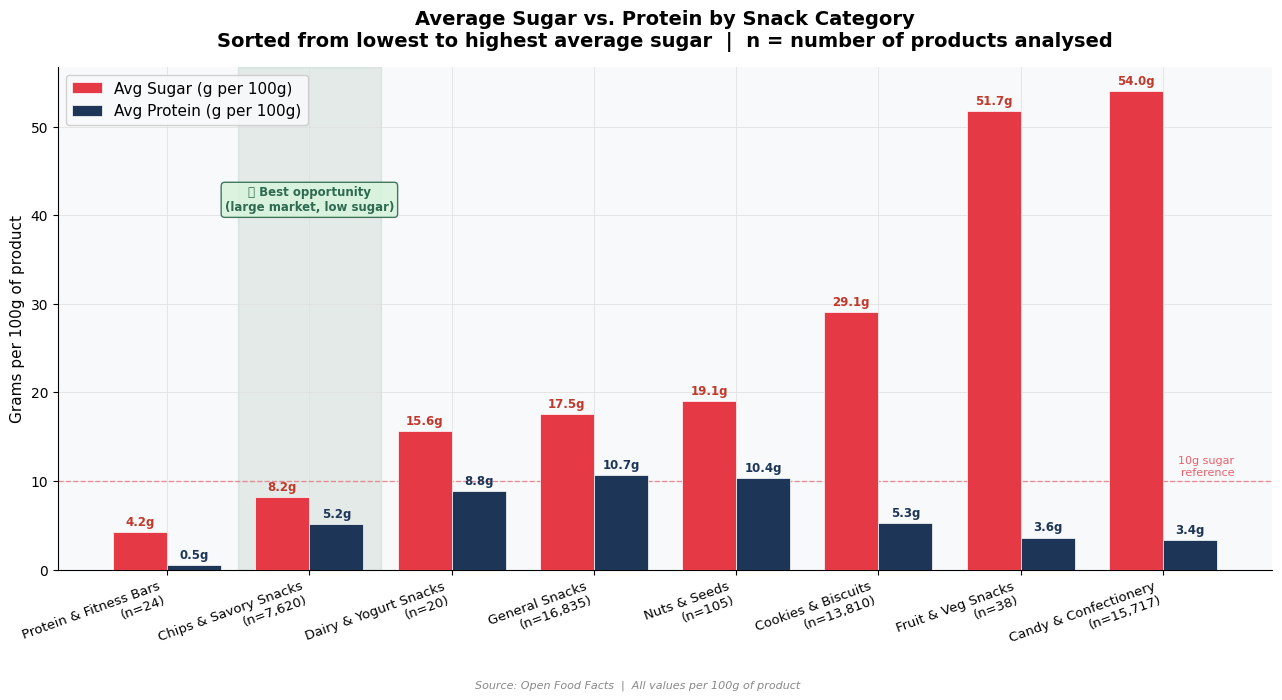

Bar chart saved as bar_chart.png


In [18]:
summary = df_snacks.groupby('primary_category').agg(
    product_count   = ('product_name',  'count'),
    avg_sugar       = ('sugars_100g',   'mean'),
    avg_protein     = ('proteins_100g', 'mean'),
    median_sugar    = ('sugars_100g',   'median'),
    median_protein  = ('proteins_100g', 'median'),
).round(2).reset_index()

# Sort by avg_sugar descending — worst at top, best at bottom
summary = summary.sort_values('avg_sugar', ascending=True)

fig, ax = plt.subplots(figsize=(13, 7))

x = np.arange(len(summary))
bar_width = 0.38

bars_sugar = ax.bar(
    x - bar_width/2,
    summary['avg_sugar'],
    width=bar_width,
    color='#E63946',
    label='Avg Sugar (g per 100g)',
    edgecolor='white',
    linewidth=0.5,
    zorder=3
)

bars_protein = ax.bar(
    x + bar_width/2,
    summary['avg_protein'],
    width=bar_width,
    color='#1D3557',
    label='Avg Protein (g per 100g)',
    edgecolor='white',
    linewidth=0.5,
    zorder=3
)

#  Value labels on top of every bar
for bar in bars_sugar:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.4,
        f'{bar.get_height():.1f}g',
        ha='center', va='bottom', fontsize=8.5, color='#C0392B', fontweight='bold'
    )

for bar in bars_protein:
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.4,
        f'{bar.get_height():.1f}g',
        ha='center', va='bottom', fontsize=8.5, color='#1D3557', fontweight='bold'
    )

#  Product count labels below each category on X axis
ax.set_xticks(x)
ax.set_xticklabels([
    f"{row['primary_category']}\n(n={row['product_count']:,})"
    for _, row in summary.iterrows()
], fontsize=9.5, rotation=20, ha='right')

#  Highlight the best opportunity bar pair
# Chips & Savory Snacks: low sugar, high product count
best_idx = summary[summary['primary_category'] == 'Chips & Savory Snacks'].index
if len(best_idx) > 0:
    best_pos = list(summary.index).index(best_idx[0])
    ax.axvspan(
        best_pos - 0.5, best_pos + 0.5,
        alpha=0.10, color='#2D6A4F', zorder=0
    )
    ax.text(
        best_pos, summary['avg_sugar'].max() * 0.75,
        '⭐ Best opportunity\n(large market, low sugar)',
        ha='center', fontsize=8.5, color='#2D6A4F', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='#D8F3DC', edgecolor='#2D6A4F', alpha=0.9)
    )

ax.set_title(
    'Average Sugar vs. Protein by Snack Category\n'
    'Sorted from lowest to highest average sugar  |  n = number of products analysed',
    fontsize=14, fontweight='bold', pad=15
)
ax.set_ylabel('Grams per 100g of product', fontsize=11)
ax.set_xlabel('')
ax.legend(fontsize=11, loc='upper left')

# Reference line at 10g sugar — the "decent" threshold
ax.axhline(y=10, color='#E63946', linewidth=1, linestyle='--', alpha=0.5)
ax.text(
    len(summary) - 0.5, 10.4,
    '10g sugar\nreference',
    fontsize=8, color='#E63946', ha='right', va='bottom', alpha=0.8
)

fig.text(
    0.5, 0.01,
    'Source: Open Food Facts  |  All values per 100g of product',
    ha='center', fontsize=8, color='#888', style='italic'
)

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.savefig('bar_chart.png', dpi=180, bbox_inches='tight')
plt.show()
print("Bar chart saved as bar_chart.png")

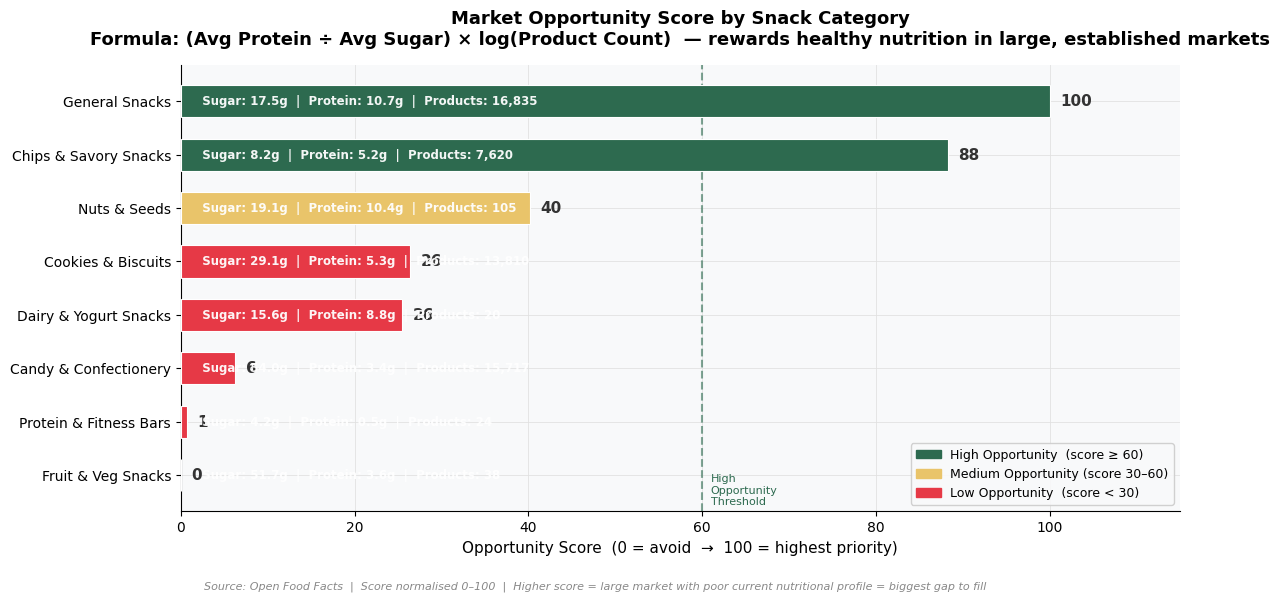

 Opportunity score chart saved as opportunity_score.png

=== FINAL OPPORTUNITY SCORES ===
      primary_category  product_count  avg_sugar  avg_protein  score_norm
        General Snacks          16835      17.54        10.70       100.0
 Chips & Savory Snacks           7620       8.23         5.15        88.3
          Nuts & Seeds            105      19.08        10.36        40.2
    Cookies & Biscuits          13810      29.06         5.28        26.4
 Dairy & Yogurt Snacks             20      15.63         8.83        25.5
 Candy & Confectionery          15717      54.00         3.37         6.3
Protein & Fitness Bars             24       4.24         0.47         0.7
    Fruit & Veg Snacks             38      51.72         3.62         0.0


In [19]:
# Calculate the opportunity score
summary['protein_sugar_ratio'] = summary['avg_protein'] / (summary['avg_sugar'] + 1)
summary['opportunity_score']   = (
    summary['protein_sugar_ratio'] * np.log1p(summary['product_count'])
).round(2)

score_min = summary['opportunity_score'].min()
score_max = summary['opportunity_score'].max()
summary['score_norm'] = (
    (summary['opportunity_score'] - score_min) / (score_max - score_min) * 100
).round(1)

summary_sorted = summary.sort_values('score_norm', ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(12, 6))

# Color each bar: green ≥ 60, yellow 30–60, red < 30
bar_colors = [
    '#2D6A4F' if s >= 60 else '#E9C46A' if s >= 30 else '#E63946'
    for s in summary_sorted['score_norm']
]

bars = ax.barh(
    summary_sorted['primary_category'],
    summary_sorted['score_norm'],
    color=bar_colors,
    edgecolor='white',
    linewidth=0.8,
    height=0.6,
    zorder=3
)

#  Rich labels on each bar
for i, (_, row) in enumerate(summary_sorted.iterrows()):
    # Score value at end of bar
    ax.text(
        row['score_norm'] + 1.2,
        i,
        f"{row['score_norm']:.0f}",
        va='center', fontsize=11, fontweight='bold',
        color='#333'
    )
    # Inline stats inside the bar
    ax.text(
        1.5, i,
        f"  Sugar: {row['avg_sugar']:.1f}g  |  "
        f"Protein: {row['avg_protein']:.1f}g  |  "
        f"Products: {row['product_count']:,}",
        va='center', fontsize=8.5, color='white', fontweight='bold',
        alpha=0.95
    )

#  Threshold line and label
ax.axvline(x=60, color='#2D6A4F', linewidth=1.5, linestyle='--', alpha=0.6)
ax.text(61, -0.6, 'High\nOpportunity\nThreshold',
        fontsize=8, color='#2D6A4F', va='bottom')

#  Legend
legend_patches = [
    mpatches.Patch(color='#2D6A4F', label='High Opportunity  (score ≥ 60)'),
    mpatches.Patch(color='#E9C46A', label='Medium Opportunity (score 30–60)'),
    mpatches.Patch(color='#E63946', label='Low Opportunity  (score < 30)'),
]
ax.legend(handles=legend_patches, loc='lower right', fontsize=9, framealpha=0.9)

ax.set_title(
    'Market Opportunity Score by Snack Category\n'
    'Formula: (Avg Protein ÷ Avg Sugar) × log(Product Count)  '
    '— rewards healthy nutrition in large, established markets',
    fontsize=13, fontweight='bold', pad=15
)
ax.set_xlabel('Opportunity Score  (0 = avoid  →  100 = highest priority)', fontsize=11)
ax.set_xlim(0, 115)
ax.set_ylabel('')

fig.text(
    0.5, 0.01,
    'Source: Open Food Facts  |  Score normalised 0–100  |  '
    'Higher score = large market with poor current nutritional profile = biggest gap to fill',
    ha='center', fontsize=8, color='#888', style='italic'
)

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.savefig('opportunity_score.png', dpi=180, bbox_inches='tight')
plt.show()
print(" Opportunity score chart saved as opportunity_score.png")

print("\n=== FINAL OPPORTUNITY SCORES ===")
print(summary_sorted[['primary_category', 'product_count',
                       'avg_sugar', 'avg_protein', 'score_norm']]
      .sort_values('score_norm', ascending=False)
      .to_string(index=False))

In [20]:

#  Target category: Chips & Savory Snacks
# General Snacks scored #1 but it's a catch-all bucket — vague, not actionable.
# "Build a General Snack" tells R&D nothing.
# Chips & Savory Snacks is a SPECIFIC, REAL shelf category (score=88),
# with 7,620 products proving consumer demand, and avg protein of only 5.2g
# — a clear, measurable gap to fill.

TARGET_CATEGORY = 'Chips & Savory Snacks'

target = df_snacks[df_snacks['primary_category'] == TARGET_CATEGORY]

# Products in the 75th–90th percentile for protein = "best in class" benchmark
p75_protein = target['proteins_100g'].quantile(0.75)
p90_protein = target['proteins_100g'].quantile(0.90)
p25_sugar   = target['sugars_100g'].quantile(0.25)
median_sugar = target['sugars_100g'].median()

blue_ocean_products = target[
    (target['proteins_100g'] >= 15) &
    (target['sugars_100g']   <= 10)
]

blue_ocean_pct = len(blue_ocean_products) / len(target) * 100

# Total snack market context
total_snacks = len(df_snacks)
total_high_protein_low_sugar = len(df_snacks[
    (df_snacks['proteins_100g'] >= 15) &
    (df_snacks['sugars_100g']   <= 10)
])
blue_ocean_market_pct = total_high_protein_low_sugar / total_snacks * 100

print("  STORY 4: The recommendation")

print(f"""
TARGET CATEGORY:  {TARGET_CATEGORY}
Product count:    {len(target):,} products (established market)
Avg sugar:        {target['sugars_100g'].mean():.1f}g per 100g
Avg protein:      {target['proteins_100g'].mean():.1f}g per 100g

BENCHMARK — Top 25% protein in this category: >{p75_protein:.1f}g
BENCHMARK — Top 10% protein in this category: >{p90_protein:.1f}g
LOW SUGAR target (bottom 25%):               <{p25_sugar:.1f}g

BLUE OCEAN GAP in {TARGET_CATEGORY}:
  Products with ≥15g protein AND ≤10g sugar: {len(blue_ocean_products)} of {len(target):,}
  That's only {blue_ocean_pct:.1f}% of the category — nearly empty

ACROSS ALL SNACK CATEGORIES:
  Products in the Blue Ocean zone: {total_high_protein_low_sugar} of {total_snacks:,}
  That's only {blue_ocean_market_pct:.1f}% of the entire snack market
""")

print("   Recommendation (Story 4 Acceptance Criteria)")
print(f"""
"Based on the data, the biggest market opportunity is in
 CHIPS & SAVORY SNACKS, specifically targeting products
 with {p75_protein:.0f}g+ of protein and less than {p25_sugar:.0f}g of sugar.

 This category contains {len(target):,} products — proving strong
 consumer demand — yet only {blue_ocean_pct:.1f}% of those products
 sit in the High Protein + Low Sugar quadrant.

 Across all {total_snacks:,} snack products analysed, just
 {blue_ocean_market_pct:.1f}% meet the Blue Ocean criteria (≥15g protein,
 ≤10g sugar), confirming the market gap is real and wide."
""")

  STORY 4: The recommendation

TARGET CATEGORY:  Chips & Savory Snacks
Product count:    7,620 products (established market)
Avg sugar:        8.2g per 100g
Avg protein:      5.2g per 100g

BENCHMARK — Top 25% protein in this category: >7.1g
BENCHMARK — Top 10% protein in this category: >10.0g
LOW SUGAR target (bottom 25%):               <0.0g

BLUE OCEAN GAP in Chips & Savory Snacks:
  Products with ≥15g protein AND ≤10g sugar: 111 of 7,620
  That's only 1.5% of the category — nearly empty

ACROSS ALL SNACK CATEGORIES:
  Products in the Blue Ocean zone: 3176 of 54,169
  That's only 5.9% of the entire snack market

   Recommendation (Story 4 Acceptance Criteria)

"Based on the data, the biggest market opportunity is in
 CHIPS & SAVORY SNACKS, specifically targeting products
 with 7g+ of protein and less than 0g of sugar.

 This category contains 7,620 products — proving strong
 consumer demand — yet only 1.5% of those products
 sit in the High Protein + Low Sugar quadrant.

 Across all

In [21]:
import re
from collections import Counter

# For products in the Blue Ocean zone (high protein, low sugar),we look at their ingredients_text and find the most common protein-contributing ingredients.
# Step 1: Isolate the Blue Ocean products across ALL categories
blue_ocean_all = df_snacks[
    (df_snacks['proteins_100g'] >= 15) &
    (df_snacks['sugars_100g']   <= 10) &
    (df_snacks['ingredients_text'].notna())   # Must have ingredient data
].copy()

print(f"Blue Ocean products with ingredient data: {len(blue_ocean_all)}")
print(f"\nSample ingredients text:")
print(blue_ocean_all['ingredients_text'].iloc[0][:300])
print("...")

Blue Ocean products with ingredient data: 3072

Sample ingredients text:
Nuts (Peanuts, Almonds), Prebiotic Blend (Tapioca Fiber, Vegetable Fiber), Protein Blend (Pea Protein Crisps [Pea Protein, Tapioca Starch], Pea Protein), Natural Flavors, Peanut Flour, Coconut Oil, Unsweetened Chocolate, Cocoa, Cocoa Butter, Sea Salt, Lion's Mane, Stevia Plant Extract, Vitamin E
...


In [22]:
# Step 2: Define protein source keywords to search for
# These are the most common protein-contributing ingredients in snack foods
# We search for these as substrings — "whey protein isolate" matches "whey"

PROTEIN_SOURCES = {
    # Animal proteins
    'whey':             'Whey Protein',
    'casein':           'Casein',
    'egg white':        'Egg White',
    'egg':              'Egg',
    'milk protein':     'Milk Protein',
    'chicken':          'Chicken',
    'tuna':             'Tuna',
    'salmon':           'Salmon',
    'beef':             'Beef',

    # Plant proteins
    'pea protein':      'Pea Protein',
    'soy protein':      'Soy Protein',
    'soy':              'Soy / Soybean',
    'peanut':           'Peanut',
    'almond':           'Almond',
    'sunflower seed':   'Sunflower Seed',
    'pumpkin seed':     'Pumpkin Seed',
    'hemp':             'Hemp Protein',
    'quinoa':           'Quinoa',
    'chickpea':         'Chickpea',
    'lentil':           'Lentil',
    'rice protein':     'Rice Protein',

    # Common high-protein bases
    'oat':              'Oats',
    'nut':              'Nuts (general)',
    'seed':             'Seeds (general)',
}

# Step 3: Count occurrences of each protein source
protein_counts = Counter()

for ingredients in blue_ocean_all['ingredients_text'].dropna():
    ingredients_lower = ingredients.lower()
    for keyword, label in PROTEIN_SOURCES.items():
        if keyword in ingredients_lower:
            protein_counts[label] += 1
            break  # Count each product once per keyword match — avoid double counting

# Step 4: Convert to DataFrame for display and charting
protein_df = pd.DataFrame(
    protein_counts.most_common(15),
    columns=['Protein Source', 'Product Count']
)
protein_df['Pct of Blue Ocean Products'] = (
    protein_df['Product Count'] / len(blue_ocean_all) * 100
).round(1)

print("  TOP PROTEIN SOURCES IN BLUE OCEAN PRODUCTS")
print(protein_df.to_string(index=False))

  TOP PROTEIN SOURCES IN BLUE OCEAN PRODUCTS
 Protein Source  Product Count  Pct of Blue Ocean Products
         Peanut            799                        26.0
  Soy / Soybean            669                        21.8
         Almond            397                        12.9
           Beef            135                         4.4
 Nuts (general)            125                         4.1
   Whey Protein            111                         3.6
    Soy Protein             62                         2.0
 Sunflower Seed             48                         1.6
   Pumpkin Seed             47                         1.5
Seeds (general)             29                         0.9
        Chicken             26                         0.8
            Egg             22                         0.7
           Oats             22                         0.7
       Chickpea             13                         0.4
         Lentil             11                         0.4


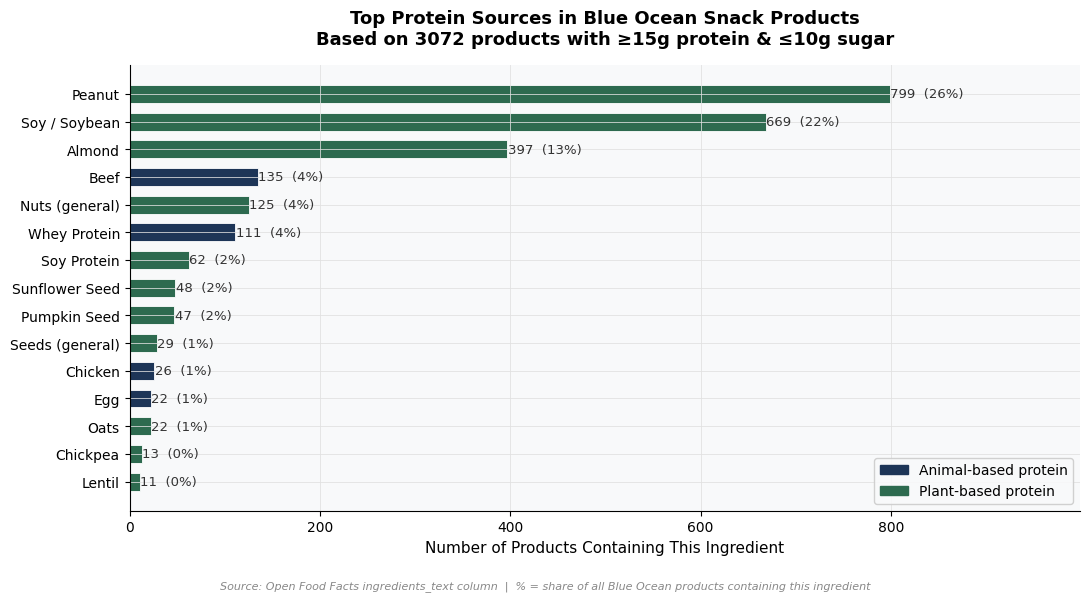

 Protein sources chart saved as protein_sources.png


In [23]:
# Step 5: Visualise it
fig, ax = plt.subplots(figsize=(11, 6))

# Color bars: animal proteins blue, plant proteins green
animal_proteins = {
    'Whey Protein', 'Casein', 'Egg White', 'Egg',
    'Milk Protein', 'Chicken', 'Tuna', 'Salmon', 'Beef'
}

bar_colors = [
    '#1D3557' if src in animal_proteins else '#2D6A4F'
    for src in protein_df['Protein Source']
]

bars = ax.barh(
    protein_df['Protein Source'],
    protein_df['Product Count'],
    color=bar_colors,
    edgecolor='white',
    linewidth=0.6,
    height=0.65
)

# Value labels
for i, (_, row) in enumerate(protein_df.iterrows()):
    ax.text(
        row['Product Count'] + 0.3,
        i,
        f"{row['Product Count']}  ({row['Pct of Blue Ocean Products']:.0f}%)",
        va='center', fontsize=9.5, color='#333'
    )

# Legend for color coding
legend_patches = [
    mpatches.Patch(color='#1D3557', label='Animal-based protein'),
    mpatches.Patch(color='#2D6A4F', label='Plant-based protein'),
]
ax.legend(handles=legend_patches, loc='lower right', fontsize=10)

ax.set_title(
    'Top Protein Sources in Blue Ocean Snack Products\n'
    f'Based on {len(blue_ocean_all)} products with ≥15g protein & ≤10g sugar',
    fontsize=13, fontweight='bold', pad=15
)
ax.set_xlabel('Number of Products Containing This Ingredient', fontsize=11)
ax.invert_yaxis()   # Highest count at top
ax.set_xlim(0, protein_df['Product Count'].max() * 1.25)

fig.text(
    0.5, 0.01,
    'Source: Open Food Facts ingredients_text column  |  '
    '% = share of all Blue Ocean products containing this ingredient',
    ha='center', fontsize=8, color='#888', style='italic'
)

plt.tight_layout(rect=[0, 0.04, 1, 1])
plt.savefig('protein_sources.png', dpi=180, bbox_inches='tight')
plt.show()
print(" Protein sources chart saved as protein_sources.png")

In [24]:
# ══════════════════════════════════════════════════════════════
#  CANDIDATE'S CHOICE: "The Reformulation Gap Analysis"
#
#  WHY I ADDED THIS:
#  The scatter plot shows WHERE the market is. The opportunity score shows WHICH category to target. But neither answers the question an R&D director will immediately ask: "How far are we from the target?"
#
#  This chart quantifies the DISTANCE each category needs to travel
#  to reach the Blue Ocean zone (≥15g protein, ≤10g sugar).
#  A category close to the target = easy reformulation win.
#  A category far from the target = requires new product architecture.

#  This transforms the analysis from "here's the gap" to "here's how hard it is to close the gap" — a genuinely actionable addition for the client's R&D team.



TARGET_PROTEIN = 15.0   # Blue Ocean protein floor
TARGET_SUGAR   = 10.0   # Blue Ocean sugar ceiling

# Calculate gap per category
summary_gap = df_snacks.groupby('primary_category').agg(
    avg_sugar       = ('sugars_100g',   'mean'),
    avg_protein     = ('proteins_100g', 'mean'),
    product_count   = ('product_name',  'count'),
).round(2).reset_index()

# Gap = how far the AVERAGE product in this category is from the target
# Positive gap = needs to increase (protein) or decrease (sugar)
# Negative gap = already meets or beats the target
summary_gap['protein_gap'] = (TARGET_PROTEIN - summary_gap['avg_protein']).round(1)
summary_gap['sugar_gap']   = (summary_gap['avg_sugar'] - TARGET_SUGAR).round(1)

# Clamp negatives to 0 — "already meets target" = 0 gap, not negative
summary_gap['protein_gap_display'] = summary_gap['protein_gap'].clip(lower=0)
summary_gap['sugar_gap_display']   = summary_gap['sugar_gap'].clip(lower=0)

# Reformulation difficulty score:
# Combine both gaps into one number (equal weight)
# Higher = harder to reformulate
summary_gap['difficulty'] = (
    summary_gap['protein_gap_display'] + summary_gap['sugar_gap_display']
).round(1)

summary_gap = summary_gap.sort_values('difficulty', ascending=True).reset_index(drop=True)

print("=== REFORMULATION GAP TABLE ===\n")
print(summary_gap[[
    'primary_category', 'avg_sugar', 'avg_protein',
    'protein_gap', 'sugar_gap', 'difficulty'
]].to_string(index=False))

=== REFORMULATION GAP TABLE ===

      primary_category  avg_sugar  avg_protein  protein_gap  sugar_gap  difficulty
 Chips & Savory Snacks       8.23         5.15          9.8       -1.8         9.8
 Dairy & Yogurt Snacks      15.63         8.83          6.2        5.6        11.8
        General Snacks      17.54        10.70          4.3        7.5        11.8
          Nuts & Seeds      19.08        10.36          4.6        9.1        13.7
Protein & Fitness Bars       4.24         0.47         14.5       -5.8        14.5
    Cookies & Biscuits      29.06         5.28          9.7       19.1        28.8
    Fruit & Veg Snacks      51.72         3.62         11.4       41.7        53.1
 Candy & Confectionery      54.00         3.37         11.6       44.0        55.6


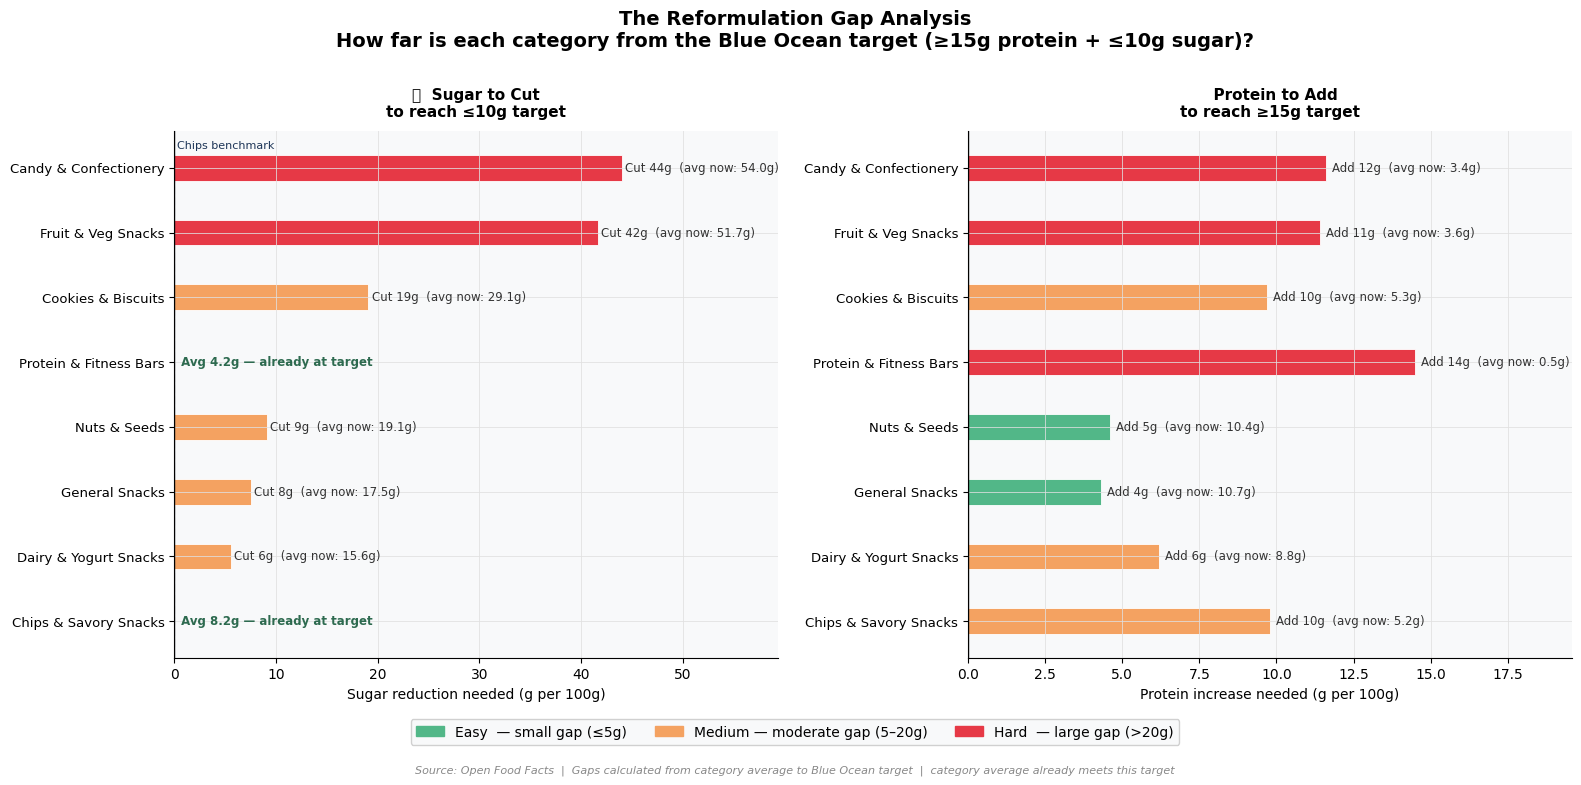

 Reformulation gap chart saved as reformulation_gap.png


In [25]:
#  Build the chart
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle(
    "The Reformulation Gap Analysis\n"
    "How far is each category from the Blue Ocean target "
    "(≥15g protein + ≤10g sugar)?",
    fontsize=14, fontweight='bold', y=1.01
)

categories = summary_gap['primary_category']
x = np.arange(len(categories))
bar_h = 0.4

#  LEFT PANEL: Sugar gap (how much sugar to cut)
ax1 = axes[0]

colors_sugar = [
    '#E63946' if g > 20 else '#F4A261' if g > 5 else '#52B788'
    for g in summary_gap['sugar_gap_display']
]

bars1 = ax1.barh(
    x, summary_gap['sugar_gap_display'],
    height=bar_h, color=colors_sugar,
    edgecolor='white', linewidth=0.6
)

for i, (gap, avg) in enumerate(zip(
    summary_gap['sugar_gap_display'],
    summary_gap['avg_sugar']
)):
    if gap == 0:
        ax1.text(0.3, i, f" Avg {avg:.1f}g — already at target",
                 va='center', fontsize=8.5, color='#2D6A4F', fontweight='bold')
    else:
        ax1.text(gap + 0.3, i,
                 f"Cut {gap:.0f}g  (avg now: {avg:.1f}g)",
                 va='center', fontsize=8.5, color='#333')

ax1.set_yticks(x)
ax1.set_yticklabels(categories, fontsize=9.5)
ax1.set_xlabel('Sugar reduction needed (g per 100g)', fontsize=10)
ax1.set_title('🍬  Sugar to Cut\nto reach ≤10g target',
              fontsize=11, fontweight='bold', pad=10)
ax1.axvline(x=0, color='#333', linewidth=1)
ax1.set_xlim(0, summary_gap['sugar_gap_display'].max() * 1.35)

# Reference: Chips & Savory as the benchmark
best_sugar_row = summary_gap[
    summary_gap['primary_category'] == 'Chips & Savory Snacks'
].iloc[0]
ax1.axvline(
    x=best_sugar_row['sugar_gap_display'],
    color='#1D3557', linewidth=1.5, linestyle='--', alpha=0.6
)
ax1.text(
    best_sugar_row['sugar_gap_display'] + 0.3,
    len(categories) - 0.7,
    'Chips benchmark',
    fontsize=8, color='#1D3557'
)

# ── RIGHT PANEL: Protein gap (how much protein to add) ──
ax2 = axes[1]

colors_protein = [
    '#E63946' if g > 10 else '#F4A261' if g > 5 else '#52B788'
    for g in summary_gap['protein_gap_display']
]

bars2 = ax2.barh(
    x, summary_gap['protein_gap_display'],
    height=bar_h, color=colors_protein,
    edgecolor='white', linewidth=0.6
)

for i, (gap, avg) in enumerate(zip(
    summary_gap['protein_gap_display'],
    summary_gap['avg_protein']
)):
    if gap == 0:
        ax2.text(0.3, i, f"Avg {avg:.1f}g — already at target",
                 va='center', fontsize=8.5, color='#2D6A4F', fontweight='bold')
    else:
        ax2.text(gap + 0.2, i,
                 f"Add {gap:.0f}g  (avg now: {avg:.1f}g)",
                 va='center', fontsize=8.5, color='#333')

ax2.set_yticks(x)
ax2.set_yticklabels(categories, fontsize=9.5)
ax2.set_xlabel('Protein increase needed (g per 100g)', fontsize=10)
ax2.set_title('  Protein to Add\nto reach ≥15g target',
              fontsize=11, fontweight='bold', pad=10)
ax2.axvline(x=0, color='#333', linewidth=1)
ax2.set_xlim(0, summary_gap['protein_gap_display'].max() * 1.35)

#  Shared legend for color coding
legend_patches_easy = [
    mpatches.Patch(color='#52B788', label='Easy  — small gap (≤5g)'),
    mpatches.Patch(color='#F4A261', label='Medium — moderate gap (5–20g)'),
    mpatches.Patch(color='#E63946', label='Hard  — large gap (>20g)'),
]
fig.legend(
    handles=legend_patches_easy,
    loc='lower center',
    ncol=3,
    fontsize=10,
    framealpha=0.9,
    bbox_to_anchor=(0.5, -0.05)
)

fig.text(
    0.5, -0.08,
    'Source: Open Food Facts  |  Gaps calculated from category average to Blue Ocean target  |  '
    'category average already meets this target',
    ha='center', fontsize=8, color='#888', style='italic'
)

plt.tight_layout()
plt.savefig('reformulation_gap.png', dpi=180, bbox_inches='tight')
plt.show()
print(" Reformulation gap chart saved as reformulation_gap.png")